In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)

%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [3]:

def evaluate_lstm(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_):
    return evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, 'LSTM')

def display_and_save(name, plot):
    fig = plot.get_figure()
    fig.savefig("result_plots/{}.eps".format(name.replace(":","").strip()), format='eps', dpi=1000)
    fig.savefig("result_plots/{}.png".format(name.replace(":","").strip()), format='png', dpi=1000)
    display(plot)

def evaluate(model, past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_, model_type='AE'):
    all_scenarios = pd.DataFrame(columns=['Scenarios', 'Number of Features', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='f1_score', ascending=False)
        return df
    
    def get_result(past_scores):
            
        df = get_best_df(past_scores)
        
        #epoch_nof_hidden
        key = int(df.iloc[0]['epoch'])
        nof = int(df.iloc[0].name[0])
        hidden = int(df.iloc[0].name[1])
        
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores):
        _, _, df = get_result(past_scores)
        #display(name)
        #display(df)
        
        group_by = 'no_of_features'
        if(model_type == 'LSTM'):
            group_by = 'hidden_layers'
        df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=[group_by])
        
        df1 = df1.first().loc[:,['f1_score', 'f1_score_20', 'time_taken']]
        df1 = df1.rename(index={1:"One", 12:"10%", 24:"20%", 48:"40%", 122:"All"})
        df1 = df1.rename(columns={"f1_score":"F1(Test+)", "f1_score_20":"F1(Test-)", "time_taken":"Duration(secs)"})
        plot = df1.plot(secondary_y = 'Duration(secs)', title=name)#,figsize=(10, 10))
        display_and_save(name, plot)
    
        
    #display("Individual Results for each Scenario")    
    view_data("Results for {} Train+".format(model),past_scores)
    view_data("Results for {} Train-".format(model),past_scores_20)
        
    def get_score(y_true, y_pred):
        f1 = me.f1_score(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    
    def accumulate_scenarios(predictions, past_scores):
        key, nof, df = get_result(past_scores)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        scores = get_score(y_true, y_pred)
        scores.update({"Model":model,"Scenarios":scenario,"Number of Features":nof})
        
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Train+_Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores))
    
    scenario = "Train+_Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_, past_scores))
    
    scenario = "Train-_Test+"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20, past_scores_20))
    
    scenario = "Train-_Test-"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions_20_, past_scores_20))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))
    
    return all_scenarios
    
    
    
    

In [4]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all-.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions-__.pkl")


'Combined Results from all Scenarios for Fully Connected'

Accuracy  F1 Score  \
Model           Scenarios    Number of Features                       
Fully Connected Train+_Test+ 48                    0.8670    0.8739   
                Train+_Test- 48                    0.7576    0.8350   
                Train-_Test+ 48                    0.8561    0.8695   
                Train-_Test- 48                    0.7504    0.8396   

                                                 Precision  Recall  
Model           Scenarios    Number of Features                     
Fully Connected Train+_Test+ 48                     0.9490  0.8098  
                Train+_Test- 48                     0.9424  0.7495  
                Train-_Test+ 48                     0.8988  0.8420  
                Train-_Test- 48                     0.8856  0.7981

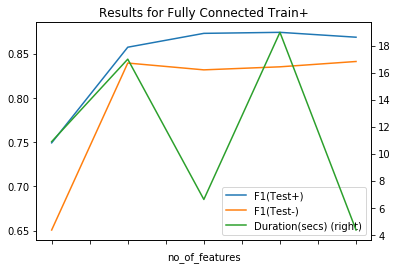

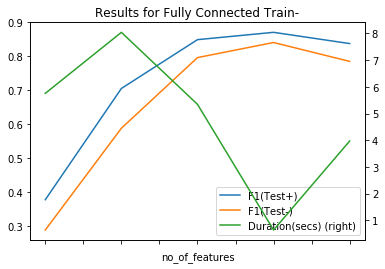

In [5]:
all_scenarios_fcn = evaluate("Fully Connected", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [6]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions-__.pkl")

'Combined Results from all Scenarios for VAE-Softmax'

Accuracy  F1 Score  Precision  \
Model       Scenarios    Number of Features                                  
VAE-Softmax Train+_Test+ 122                   0.8948    0.9036     0.9441   
            Train+_Test- 122                   0.8173    0.8814     0.9402   
            Train-_Test+ 48                    0.7195    0.6942     0.9151   
            Train-_Test- 48                    0.8015    0.8700     0.9373   

                                             Recall  
Model       Scenarios    Number of Features          
VAE-Softmax Train+_Test+ 122                 0.8665  
            Train+_Test- 122                 0.8296  
            Train-_Test+ 48                  0.5592  
            Train-_Test- 48                  0.8118

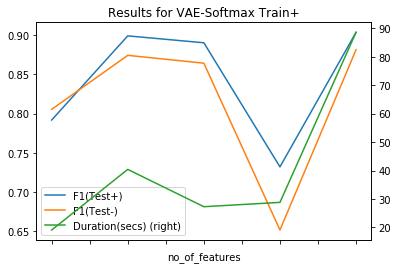

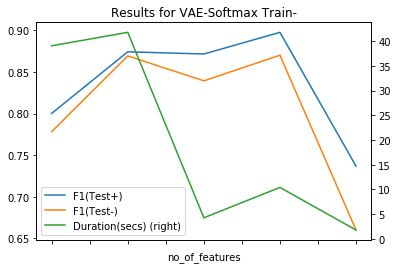

In [7]:
all_scenarios_vae_sm = evaluate("VAE-Softmax", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [8]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_vae_only_nsl_kdd_all-.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_vae_only_nsl_kdd_predictions-__.pkl")

'Combined Results from all Scenarios for VAE-GenerateLabels'

Accuracy  F1 Score  \
Model              Scenarios    Number of Features                       
VAE-GenerateLabels Train+_Test+ 1                     0.5692    0.7255   
                   Train+_Test- 1                     0.8184    0.9001   
                   Train-_Test+ 1                     0.5692    0.7255   
                   Train-_Test- 1                     0.8184    0.9001   

                                                    Precision  Recall  
Model              Scenarios    Number of Features                     
VAE-GenerateLabels Train+_Test+ 1                      0.5692     1.0  
                   Train+_Test- 1                      0.8184     1.0  
                   Train-_Test+ 1                      0.5692     1.0  
                   Train-_Test- 1                      0.8184     1.0

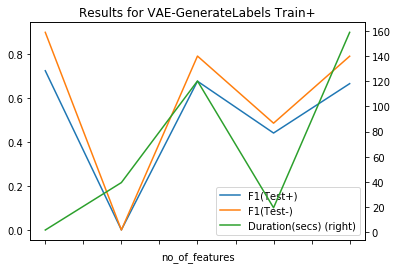

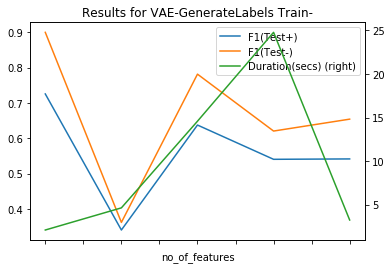

In [9]:
all_scenarios_vae = evaluate("VAE-GenerateLabels", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [10]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
past_scores_20 = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")
predictions_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions__.pkl")
predictions_20 = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-.pkl")
predictions_20_ = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions-__.pkl")

'Combined Results from all Scenarios for LSTM'

Accuracy  F1 Score  Precision  Recall
Model Scenarios    Number of Features                                       
LSTM  Train+_Test+ 1                     0.9949    0.9955     0.9915  0.9995
      Train+_Test- 1                     0.9949    0.9955     0.9915  0.9995
      Train-_Test+ 1                     0.9992    0.9993     0.9985  1.0000
      Train-_Test- 1                     0.9992    0.9993     0.9985  1.0000

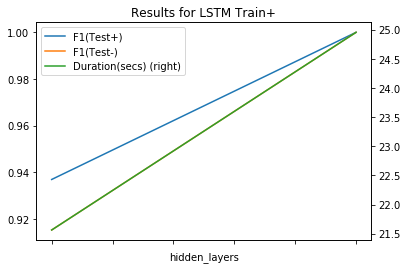

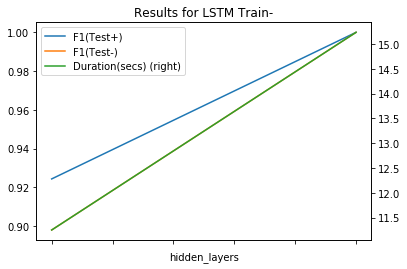

In [11]:
all_scenarios_lstm = evaluate_lstm("LSTM", past_scores, past_scores_20, predictions, predictions_, predictions_20, predictions_20_)

In [12]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae_sm, all_scenarios_vae, all_scenarios_lstm],axis=0)

In [13]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Scenarios', 'Model')
all_scenarios_pivot

Model,Fully Connected,LSTM,VAE-GenerateLabels,VAE-Softmax
Scenarios,,,,
Train+_Test+,0.8739,0.9955,0.7255,0.9036
Train+_Test-,0.8350,0.9955,0.9001,0.8814
Train-_Test+,0.8695,0.9993,0.7255,0.6942
Train-_Test-,0.8396,0.9993,0.9001,0.8700


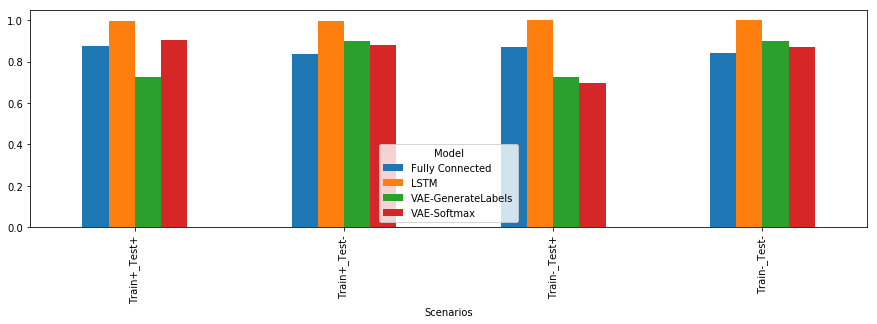

In [14]:
display_and_save("All Results with Train_Test in X-axis",all_scenarios_pivot.plot(kind='bar', figsize=[15,4]))

In [15]:
all_scenarios_display = all_scenarios.loc[:,[ 'Scenarios', 'F1 Score', 'Model']]
all_scenarios_pivot = all_scenarios_display.pivot_table('F1 Score', 'Model', 'Scenarios')
all_scenarios_pivot

Scenarios,Train+_Test+,Train+_Test-,Train-_Test+,Train-_Test-
Model,,,,
Fully Connected,0.8739,0.8350,0.8695,0.8396
LSTM,0.9955,0.9955,0.9993,0.9993
VAE-GenerateLabels,0.7255,0.9001,0.7255,0.9001
VAE-Softmax,0.9036,0.8814,0.6942,0.8700


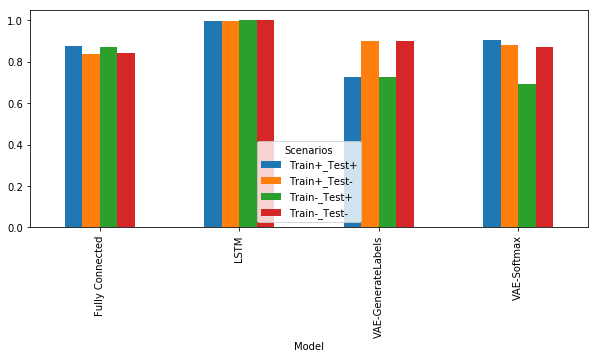

In [16]:
display_and_save("All Results with Models in X Axis",all_scenarios_pivot.plot(kind='bar', figsize=[10,4]))

In [18]:
#%%bash
#zip -r result_plots.zip result_plots